In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data_collection/data.csv")

df.drop("Volume",1,inplace=True)

df.info()


df.drop(df[df.High > 1].index, inplace=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4662 entries, 0 to 4661
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4662 non-null   object 
 1   High       4662 non-null   float64
 2   Low        4662 non-null   float64
 3   Open       4662 non-null   float64
 4   Close      4662 non-null   float64
 5   Adj Close  4662 non-null   float64
 6   count      4662 non-null   float64
dtypes: float64(6), object(1)
memory usage: 255.1+ KB


In [2]:
import tensorflow as tf

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

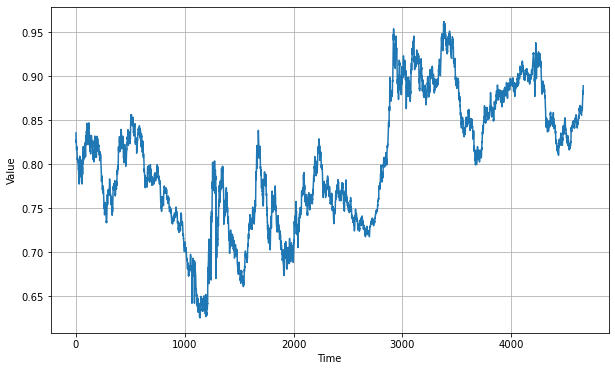

In [5]:
series = np.array(df.Close)
time = np.array(df.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 4640
time_train = time[:split_time] 
x_train = series[:split_time] 
time_valid = time[split_time:] 
x_valid = series[split_time:] 

In [34]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [35]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [42]:
window_size = 60
batch_size = 1
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4640,)


In [43]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [44]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

In [48]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150, callbacks=[es_callback])

In [49]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

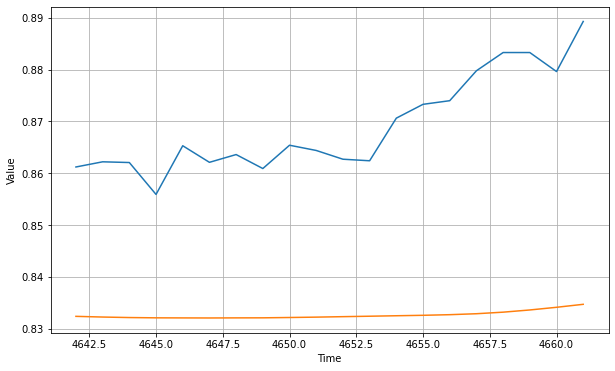

In [47]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [51]:
x_train.shape

(4640,)

In [53]:
a = rnn_forecast[:split_time, -1, 0]
a.shape

(4601,)

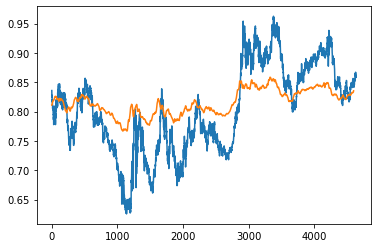

In [56]:
plt.plot(x_train)
plt.plot(a)

In [58]:
window_size = 60
batch_size = 100
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4640,)


In [59]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.3),  
  tf.keras.layers.Dense(1)
])

In [60]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

In [61]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150, callbacks=[es_callback])

Epoch 1/150
46/46 [==============================] - 10s 109ms/step - loss: 0.3216 - mae: 0.7981
Epoch 2/150
46/46 [==============================] - 5s 107ms/step - loss: 0.3204 - mae: 0.7966
Epoch 3/150
46/46 [==============================] - 5s 107ms/step - loss: 0.3190 - mae: 0.7949
Epoch 4/150
46/46 [==============================] - 5s 107ms/step - loss: 0.3175 - mae: 0.7931
Epoch 5/150
46/46 [==============================] - 5s 106ms/step - loss: 0.3163 - mae: 0.7915
Epoch 6/150
46/46 [==============================] - 5s 106ms/step - loss: 0.3149 - mae: 0.7897
Epoch 7/150
46/46 [==============================] - 5s 107ms/step - loss: 0.3136 - mae: 0.7880
Epoch 8/150
46/46 [==============================] - 5s 107ms/step - loss: 0.3123 - mae: 0.7865
Epoch 9/150
46/46 [==============================] - 5s 107ms/step - loss: 0.3110 - mae: 0.7847
Epoch 10/150
46/46 [==============================] - 5s 108ms/step - loss: 0.3096 - mae: 0.7830
Epoch 11/150
46/46 [==================

In [62]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

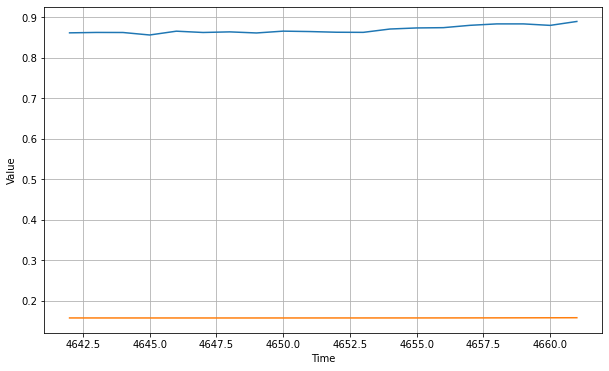

In [63]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [64]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150, callbacks=[es_callback])

Epoch 1/150
46/46 [==============================] - 11s 130ms/step - loss: 0.2201 - mae: 0.6572
Epoch 2/150
46/46 [==============================] - 6s 129ms/step - loss: 0.2199 - mae: 0.6569
Epoch 3/150
46/46 [==============================] - 6s 132ms/step - loss: 0.2194 - mae: 0.6561
Epoch 4/150
46/46 [==============================] - 6s 126ms/step - loss: 0.2189 - mae: 0.6553
Epoch 5/150
46/46 [==============================] - 6s 126ms/step - loss: 0.2186 - mae: 0.6549
Epoch 6/150
46/46 [==============================] - 6s 127ms/step - loss: 0.2180 - mae: 0.6539
Epoch 7/150
46/46 [==============================] - 6s 127ms/step - loss: 0.2178 - mae: 0.6536
Epoch 8/150
46/46 [==============================] - 6s 128ms/step - loss: 0.2174 - mae: 0.6530
Epoch 9/150
46/46 [==============================] - 6s 132ms/step - loss: 0.2169 - mae: 0.6522
Epoch 10/150
46/46 [==============================] - 6s 131ms/step - loss: 0.2165 - mae: 0.6515
Epoch 11/150
46/46 [==================

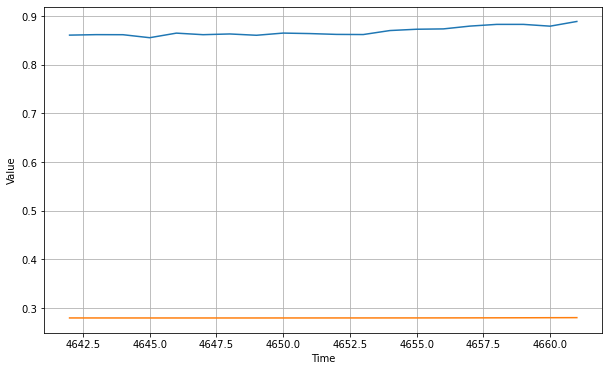

In [65]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [66]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150, callbacks=[es_callback])

Epoch 1/150
46/46 [==============================] - 12s 128ms/step - loss: 0.1515 - mae: 0.5390
Epoch 2/150
46/46 [==============================] - 6s 129ms/step - loss: 0.1473 - mae: 0.5306
Epoch 3/150
46/46 [==============================] - 6s 127ms/step - loss: 0.1425 - mae: 0.5212
Epoch 4/150
46/46 [==============================] - 6s 126ms/step - loss: 0.1379 - mae: 0.5119
Epoch 5/150
46/46 [==============================] - 6s 125ms/step - loss: 0.1339 - mae: 0.5034
Epoch 6/150
46/46 [==============================] - 6s 124ms/step - loss: 0.1294 - mae: 0.4940
Epoch 7/150
46/46 [==============================] - 6s 127ms/step - loss: 0.1257 - mae: 0.4860
Epoch 8/150
46/46 [==============================] - 6s 126ms/step - loss: 0.1219 - mae: 0.4777
Epoch 9/150
46/46 [==============================] - 6s 128ms/step - loss: 0.1181 - mae: 0.4691
Epoch 10/150
46/46 [==============================] - 6s 129ms/step - loss: 0.1145 - mae: 0.4609
Epoch 11/150
46/46 [==================

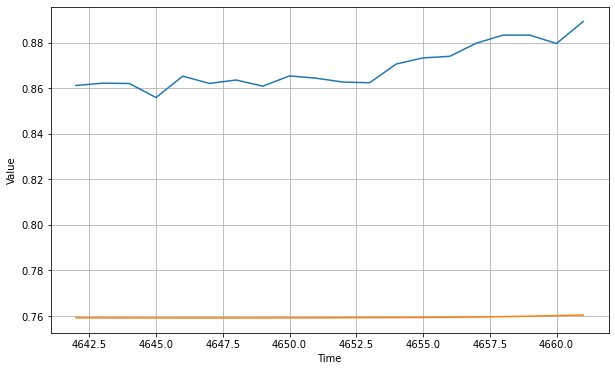

In [67]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [68]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150, callbacks=[es_callback])

Epoch 1/150
46/46 [==============================] - 11s 115ms/step - loss: 0.0281 - mae: 0.1950
Epoch 2/150
46/46 [==============================] - 5s 113ms/step - loss: 0.0284 - mae: 0.1959
Epoch 3/150
46/46 [==============================] - 5s 113ms/step - loss: 0.0281 - mae: 0.1951
Epoch 4/150
46/46 [==============================] - 5s 114ms/step - loss: 0.0280 - mae: 0.1947
Epoch 5/150
46/46 [==============================] - 5s 113ms/step - loss: 0.0281 - mae: 0.1951
Epoch 6/150
46/46 [==============================] - 5s 114ms/step - loss: 0.0278 - mae: 0.1940
Epoch 7/150
46/46 [==============================] - 5s 114ms/step - loss: 0.0280 - mae: 0.1946
Epoch 8/150
46/46 [==============================] - 6s 117ms/step - loss: 0.0279 - mae: 0.1945
Epoch 9/150
46/46 [==============================] - 6s 122ms/step - loss: 0.0279 - mae: 0.1945
Epoch 10/150
46/46 [==============================] - 6s 133ms/step - loss: 0.0278 - mae: 0.1943
Epoch 11/150
46/46 [==================

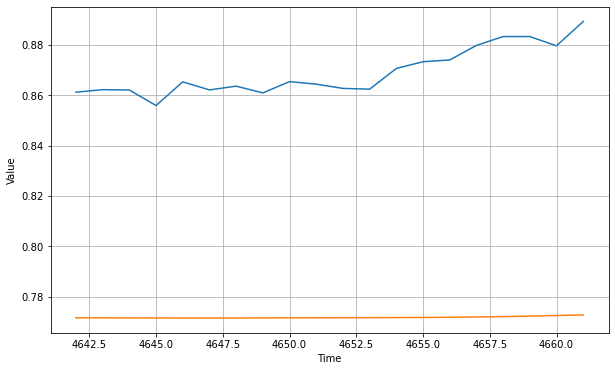

In [70]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

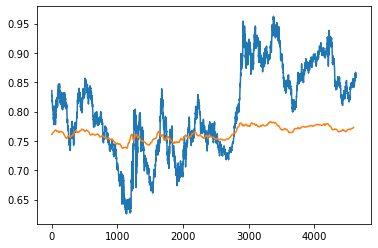

In [72]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
a = rnn_forecast[:split_time, -1, 0]
plt.plot(x_train)
plt.plot(a)

In [93]:
window_size = 120
batch_size = 100
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4640,)


In [78]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=20, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.3),  
  tf.keras.layers.Dense(1)
])

In [79]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

In [80]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_set,epochs=150, callbacks=[es_callback])

Epoch 1/150
46/46 [==============================] - 16s 234ms/step - loss: 0.3577 - mse: 0.7154
Epoch 2/150
46/46 [==============================] - 11s 242ms/step - loss: 0.3414 - mse: 0.6828
Epoch 3/150
46/46 [==============================] - 11s 240ms/step - loss: 0.3316 - mse: 0.6631
Epoch 4/150
46/46 [==============================] - 11s 241ms/step - loss: 0.3227 - mse: 0.6454
Epoch 5/150
46/46 [==============================] - 12s 245ms/step - loss: 0.3143 - mse: 0.6286
Epoch 6/150
46/46 [==============================] - 11s 239ms/step - loss: 0.3070 - mse: 0.6140
Epoch 7/150
46/46 [==============================] - 11s 240ms/step - loss: 0.3000 - mse: 0.5999
Epoch 8/150
46/46 [==============================] - 12s 245ms/step - loss: 0.2928 - mse: 0.5856
Epoch 9/150
46/46 [==============================] - 12s 245ms/step - loss: 0.2856 - mse: 0.5711
Epoch 10/150
46/46 [==============================] - 11s 239ms/step - loss: 0.2792 - mse: 0.5583
Epoch 11/150
46/46 [=========

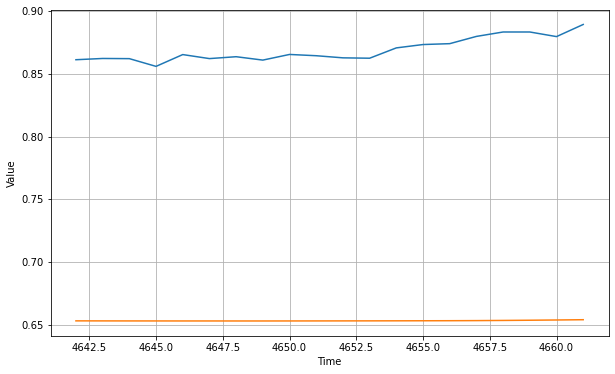

In [81]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

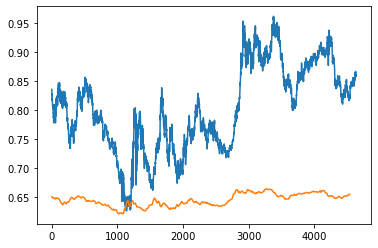

In [82]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
a = rnn_forecast[:split_time, -1, 0]
plt.plot(x_train)
plt.plot(a)

In [98]:
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [102]:
model = Sequential()
model.add(LSTM(20, activation='relu', input_shape=(window_size, 1), return_sequences=True))
model.add(LSTM(10, activation='relu'))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [103]:

history = model.fit(train_set,epochs=150, callbacks=[es_callback])

Epoch 1/150
46/46 [==============================] - 9s 112ms/step - loss: 0.1668
Epoch 2/150
46/46 [==============================] - 5s 112ms/step - loss: 0.0406
Epoch 3/150
46/46 [==============================] - 5s 107ms/step - loss: 0.0378
Epoch 4/150
46/46 [==============================] - 5s 106ms/step - loss: 0.0369
Epoch 5/150
46/46 [==============================] - 5s 107ms/step - loss: 0.0350
Epoch 6/150
46/46 [==============================] - 5s 106ms/step - loss: 0.0326
Epoch 7/150
46/46 [==============================] - 5s 106ms/step - loss: 0.0318
Epoch 8/150
46/46 [==============================] - 5s 105ms/step - loss: 0.0306
Epoch 9/150
46/46 [==============================] - 5s 105ms/step - loss: 0.0287
Epoch 10/150
46/46 [==============================] - 5s 106ms/step - loss: 0.0281
Epoch 11/150
46/46 [==============================] - 5s 107ms/step - loss: 0.0264
Epoch 12/150
46/46 [==============================] - 5s 106ms/step - loss: 0.0247
Epoch 13/150


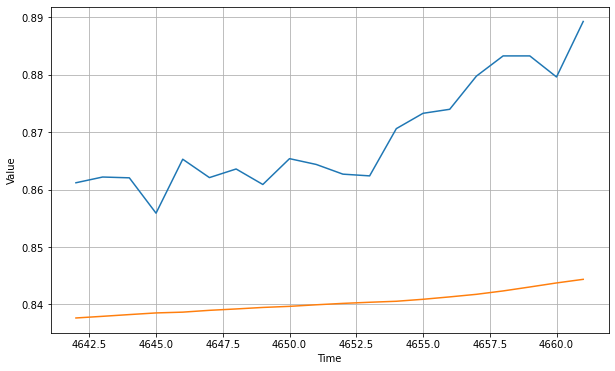

In [106]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [105]:
rnn_forecast.shape

(4541, 1)